# Inicializar

In [1]:
from Modelos.base_model import base_model
from Modelos.serie_model import serie_model
from Modelos.parallel_model import parallel_model
from Modelos.hibrid_model import hibrid_model
from utils.utils import mostrarResultadosTabla, generate_equidistant_list, graficar_costos_minimizados

In [2]:
totalNodes = 4
linkCost = 10
costByNodeType = {0: 5, 1: 12, 2: 20}
reliabilityByNodeType = {0: 0.6, 1: 0.7, 2: 0.8}
baseModel = base_model(totalNodes, costByNodeType)

Restricted license - for non-production use only - expires 2026-11-23


# Pruebas

## Serie

In [3]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo serie
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
seriesMinReliability = reliabilityByNodeType[0] ** totalNodes
seriesMaxReliability = reliabilityByNodeType[2] ** totalNodes
seriesRequiredReliabilities = generate_equidistant_list(seriesMinReliability, seriesMaxReliability, 10)
print(seriesMinReliability, seriesMaxReliability)
print(seriesRequiredReliabilities)

0.1296 0.4096000000000001
[0.155054545455, 0.180509090909, 0.205963636364, 0.231418181818, 0.256872727273, 0.282327272727, 0.307781818182, 0.333236363636, 0.358690909091, 0.384145454545]


In [4]:
# Crear y optimizar el modelo en serie
try:
    seriesMinCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, seriesRequiredReliabilities[5])
    mostrarResultadosTabla(totalNodes, seriesMinCost, seriesVars)
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 4
Resultado de la Optimización:
Costo Total: 94.0
Costo nodos: 64.0
Costo enlaces: 30.0
Nodos activos (x):
   Low Cost  Mid Cost  High Cost
1         0         0          1
2         0         1          0
3         0         1          0
4         0         0          1


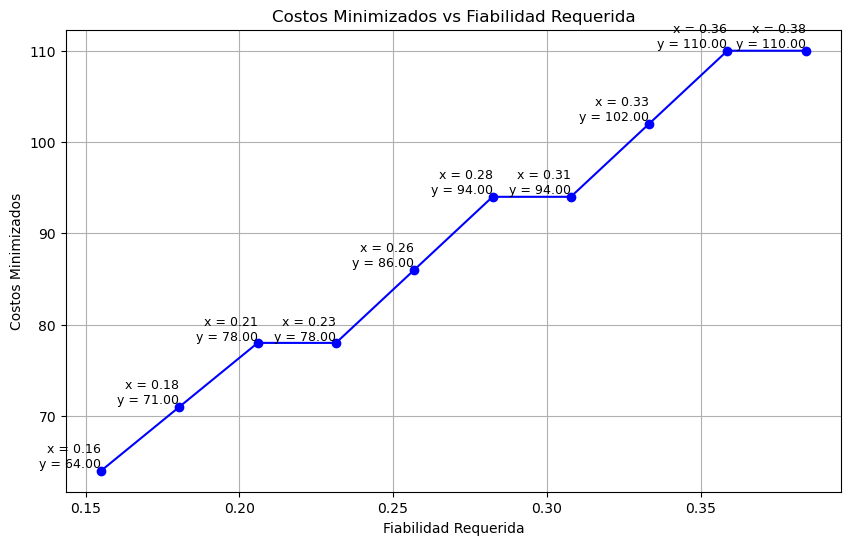

In [5]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    serieMinimizedCosts = []
    for reqReliability in seriesRequiredReliabilities:
        minCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        serieMinimizedCosts.append(minCost)
    graficar_costos_minimizados(seriesRequiredReliabilities, serieMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

## Paralelo

In [6]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo en paralelo
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
parallelMinReliability = 1 - ((1 - reliabilityByNodeType[0]) ** totalNodes)
parallelMaxReliability = 1 - ((1 - reliabilityByNodeType[2]) ** totalNodes)
parallelRequiredReliabilities = generate_equidistant_list(parallelMinReliability, parallelMaxReliability, 10)
print(parallelMinReliability, parallelMaxReliability)
print(parallelRequiredReliabilities)

0.9744 0.9984
[0.976581818182, 0.978763636364, 0.980945454545, 0.983127272727, 0.985309090909, 0.987490909091, 0.989672727273, 0.991854545455, 0.994036363636, 0.996218181818]


In [7]:
# Crear y optimizar el modelo en paralelo
try:
    parallelMinCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, parallelRequiredReliabilities[3])
    mostrarResultadosTabla(totalNodes, parallelMinCost, parallelVars)
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 4
Resultado de la Optimización:
Costo Total: 94.0
Costo nodos: 34.0
Costo enlaces: 60.0
Nodos activos (x):
   Low Cost  Mid Cost  High Cost
1         0         1          0
2         1         0          0
3         1         0          0
4         0         1          0


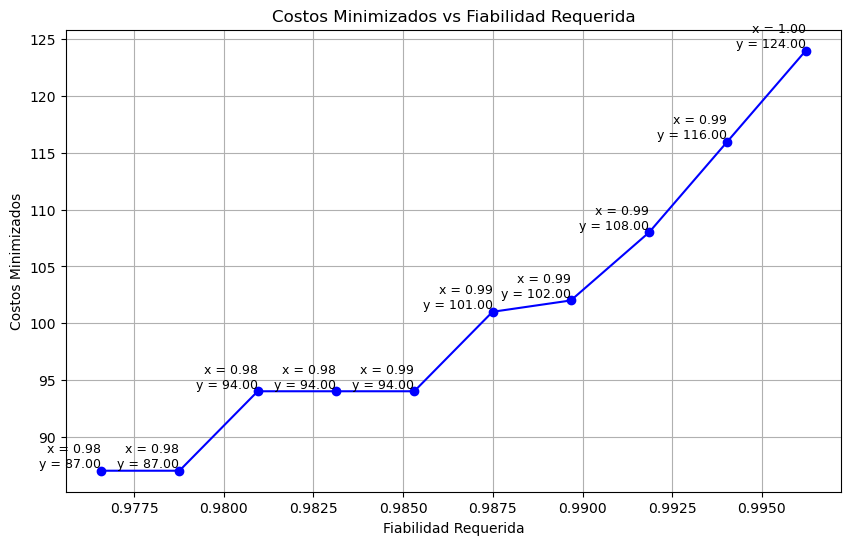

In [8]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    parallelMinimizedCosts = []
    for reqReliability in parallelRequiredReliabilities:
        minCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        parallelMinimizedCosts.append(minCost)
    graficar_costos_minimizados(parallelRequiredReliabilities, parallelMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

## Hibrido

In [9]:
# Crear y optimizar el modelo híbrido
try:
    hybridMinCost, hybridVars, hybridModel = hibrid_model(baseModel, totalNodes, linkCost)
    mostrarResultadosTabla(totalNodes, hybridMinCost, hybridVars, "hibrido")
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 4
Resultado de la Optimización:
Costo Total: 60.0
Costo nodos: 20.0
Costo enlaces: 40.0
Nodos activos (x):
   Low Cost  Mid Cost  High Cost
1         1         0          0
2         1         0          0
3         1         0          0
4         1         0          0
Nodos activos (y):
   Subred 0  Subred 1
1         1         0
2         0         1
3         0         1
4         0         1
